# Does Political Structure Influence Voter Turnout in Industrialized Democracy?

### STAT 301 - Group Project - Proposal

In [1]:
# Load the necessary packages for the Project Proposal
library(GGally)
library(dplyr)
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(faux)

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.5
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

************
Welcome to faux. For support and examples visit:
https://debruine.github.io/faux/
- Get and set global package options with: faux_options()
************


Attaching package: 'faux'


The following object is masked from 'package:purrr':

    %

## 1. Introduction

The two competing explanations for differences in voter turnout between countries in the literature is either cultural or institution-based. The cultural argument traditionally cites Almond and Verba’s (1963) work that turnout depends on the unique, participatory culture of each country. Alternatively, the classic work by Jackman (1987) suggests the structure of a country’s political institutions has a “major and predictable” impact on voting rates regardless of cultural differences (p. 406). However, Jackson’s shortcoming was he could only compare 19 countries in the 1970s. Thus his results might not be generalizable to all elections and industrialized democracies. Subsequent studies mostly focused on country-specific elections but have cast doubt on whether institutional factors have an effect (Freitag, 2010). This study, therefore, aims to test Jackson’s claims that voter turnout is majorly impacted by the structure of political institutions in industrialized democracies by using a more comprehensive and updated dataset.

The QOG dataset will be from the Quality of Government Institute, where researchers compiled measures for each country from hundreds of sources (Teorell et. al., 2022). The dataset has information from 1960 to 2018 for the 36 OECD and EU democracies, however, after cleaning the data, 35 country observations remain. We base our methods on Jackman (1987), and will build a regression of the voter turnout against institutional measures of electoral competitiveness, multipartyism, electoral proportionality, and whether the legislature is bicameral.

We estimate institutionalized competition using Vanhanen (2019)’s method based on the percentage of votes that go to small parties, multipartyism by the number of influential parties, electoral proportionality on a dummy whether proportional representation systems exist, and bicameralism (the presence of two legislatures) using a dummy with 0 for unitary and 1 for bicameral governments.

The dataset can be found at: https://www.qogdata.pol.gu.se/data/codebook_std_jan22.pdf

## 2. Data Wrangling and Cleaning

### 2.1 Importing the Dataset

In [2]:
url <- "https://www.qogdata.pol.gu.se/data/qog_std_ts_jan22.csv"
QOG_dataset_original <- read_delim(url, ",")

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 15168 Columns: 1913
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr    (7): cname, cname_qog, ccodealp, version, cname_year, ccodealp_year, ...
dbl (1903): ccode, year, ccode_qog, ccodecow, aid_cpnc, aid_cpsc, aid_crnc, ...
lgl    (3): psi_cpsi2, psi_edate2, psi_psi2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 2.2 Cleaning the Dataset

In [3]:
# For cleaning up the dataset we will be doing the following:
# - We will be filtering out the columns other than "cname", "year", "van_part", "van_comp", jw_bicameral", "br_pvote",
#   and "cpds_enpv".
# - We will be renaming our selected variables for better readability.
# - We will be filtering out the NA rows when applicable.

QOG_cleaned <- QOG_dataset_original %>% 
                select(cname, van_part, van_comp, jw_bicameral, br_pvote, cpds_enpv) %>%
                filter(cname != is.na(cname),
                       van_part != is.na(van_part),
                       van_comp != is.na(van_comp),
                       # jw_bicameral != is.na(jw_bicameral),
                       cpds_enpv != is.na(cpds_enpv)) 

colnames(QOG_cleaned) <- c("country", "voter_turnout", "elec_comp", "gov_type", "prop_rep", "num_party")

QOG_cleaned <- QOG_cleaned %>%
                mutate(gov_type = ifelse(is.na(gov_type), 0, gov_type)) %>%
                mutate(gov_type = ifelse(gov_type == 0, "unitary", "bicaremel")) %>%
                mutate(prop_rep = ifelse(prop_rep == 0, "no", "yes")) %>%
                filter(prop_rep != is.na(prop_rep))

head(QOG_cleaned)

country,voter_turnout,elec_comp,gov_type,prop_rep,num_party
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
Australia,51.0,57.1,unitary,no,2.973527
Australia,51.1,52.0,unitary,no,2.814222
Australia,50.1,52.0,unitary,no,2.814222
Australia,50.3,54.5,unitary,no,2.792805
Australia,50.3,54.5,unitary,no,2.792805
Australia,51.3,54.5,unitary,no,2.792805


***[THING TO DO]: What is the proportion of the missing data? Do you know the missingness mechanism?***

## 3. Methodology and Results

### 3.1 Summary Tables

We will be building summary tables just to see the averages for the data, by country, government type, and whether there is a proportional representation or not.

**Table 1: Summary of the Data by Country**

In [4]:
QOG_by_country <- QOG_cleaned %>% select(-gov_type, -prop_rep) %>%
                    group_by(country) %>%
                    summarize(avg_voter_turnout = mean(voter_turnout),
                              avg_elec_comp = mean(elec_comp),
                              avg_num_party = mean(num_party))
head(QOG_by_country)

country,avg_voter_turnout,avg_elec_comp,avg_num_party
<chr>,<dbl>,<dbl>,<dbl>
Australia,58.09051,57.47119,3.078265
Austria,61.09593,58.54407,3.167171
Belgium,60.26864,68.20339,7.853640
Bulgaria,53.35724,54.97000,4.442549
Canada,44.63186,58.11695,3.312809
Croatia,54.46421,51.51158,5.927319


***[THING TO DO]: Explain Table 1***

**Table 2: Summary of the Data by Government Type**

In [5]:
QOG_by_gov_type <- QOG_cleaned %>% select(-country, -prop_rep) %>%
                    group_by(gov_type) %>%
                    summarize(avg_voter_turnout = mean(voter_turnout),
                              avg_elec_comp = mean(elec_comp),
                              avg_num_party = mean(num_party))
QOG_by_gov_type

gov_type,avg_voter_turnout,avg_elec_comp,avg_num_party
<chr>,<dbl>,<dbl>,<dbl>
bicaremel,55.83911,59.77002,4.587733
unitary,53.25492,59.76764,4.305824


***[THING TO DO]: Explain Table 2***

**Table 3: Summary of the Data by whether there is proportional representation or not**

In [6]:
QOG_by_prop_rep <- QOG_cleaned %>% select(-country, -gov_type) %>%
                    group_by(prop_rep) %>%
                    summarize(avg_voter_turnout = mean(voter_turnout),
                              avg_elec_comp = mean(elec_comp),
                              avg_num_party = mean(num_party))
QOG_by_prop_rep

prop_rep,avg_voter_turnout,avg_elec_comp,avg_num_party
<chr>,<dbl>,<dbl>,<dbl>
no,50.66212,56.78629,3.561606
yes,55.01874,60.77583,4.654132


***[THING TO DO]: Explain Table 3***

### 3.2 Preliminary Results and Visualizations

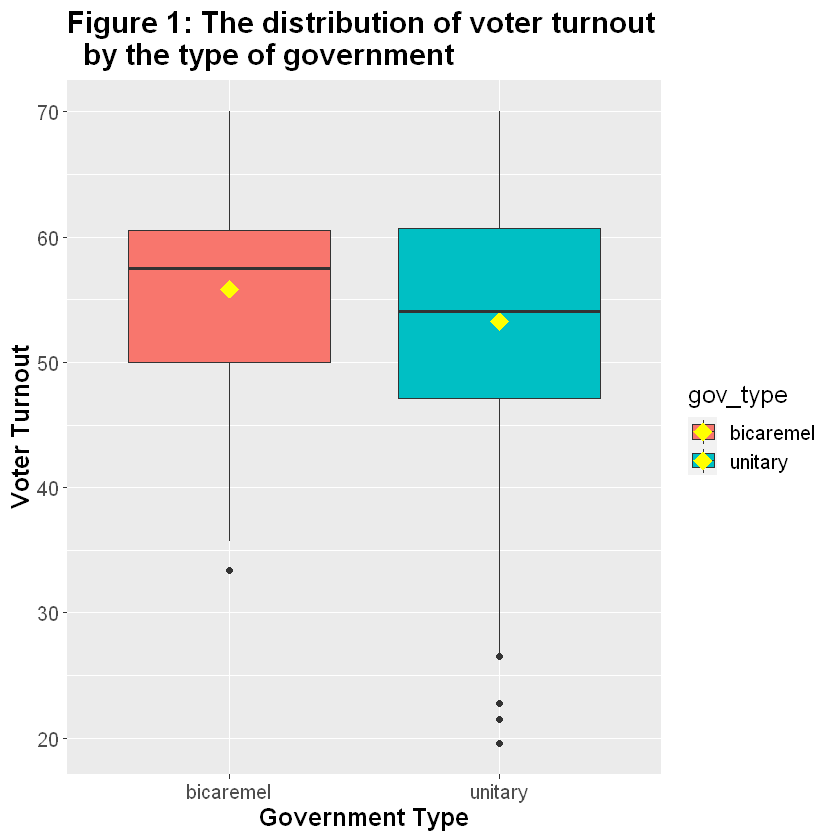

In [7]:
gov_type_boxplots <- QOG_cleaned %>%
  ggplot() +
  geom_boxplot(aes(gov_type, voter_turnout, fill = gov_type)) +
  theme(
    text = element_text(size = 12),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  ggtitle("Figure 1: The distribution of voter turnout 
  by the type of government") +
  theme(text = element_text(size = 15)) +
  xlab("Government Type") +
  ylab("Voter Turnout") +
  stat_summary(aes(gov_type, voter_turnout, fill = gov_type),
    fun = mean, colour = "yellow", geom = "point",
    shape = 18, size = 5
  )

gov_type_boxplots

The mean voter turnout for the unitary government type is 5% lower than that for bicaremelism, however, the variance is larger for unitary than that for bicaremelism. We can also see that there are more outliers for the unitary government type.

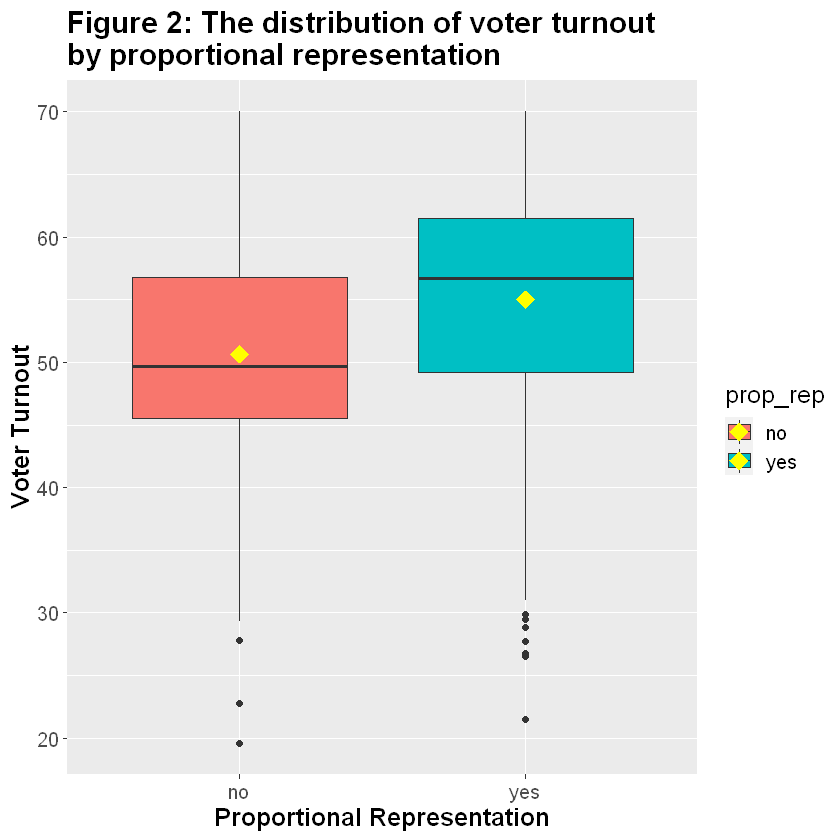

In [8]:
prop_rep_boxplots <- QOG_cleaned %>%
    ggplot() +
    geom_boxplot(aes(prop_rep, voter_turnout, fill = prop_rep)) +
    theme(
      text = element_text(size = 11),
      plot.title = element_text(face = "bold"),
      axis.title = element_text(face = "bold")
    ) +
    ggtitle("Figure 2: The distribution of voter turnout 
by proportional representation") +
    theme(text = element_text(size = 15)) +
    xlab("Proportional Representation") +
    ylab("Voter Turnout") +
    stat_summary(aes(prop_rep, voter_turnout, fill = prop_rep),
      fun = mean, colour = "yellow", geom = "point",
      shape = 18, size = 5
    )

prop_rep_boxplots

We can see that the mean for yes is 7% higher than the mean for no, with similar variances for both.

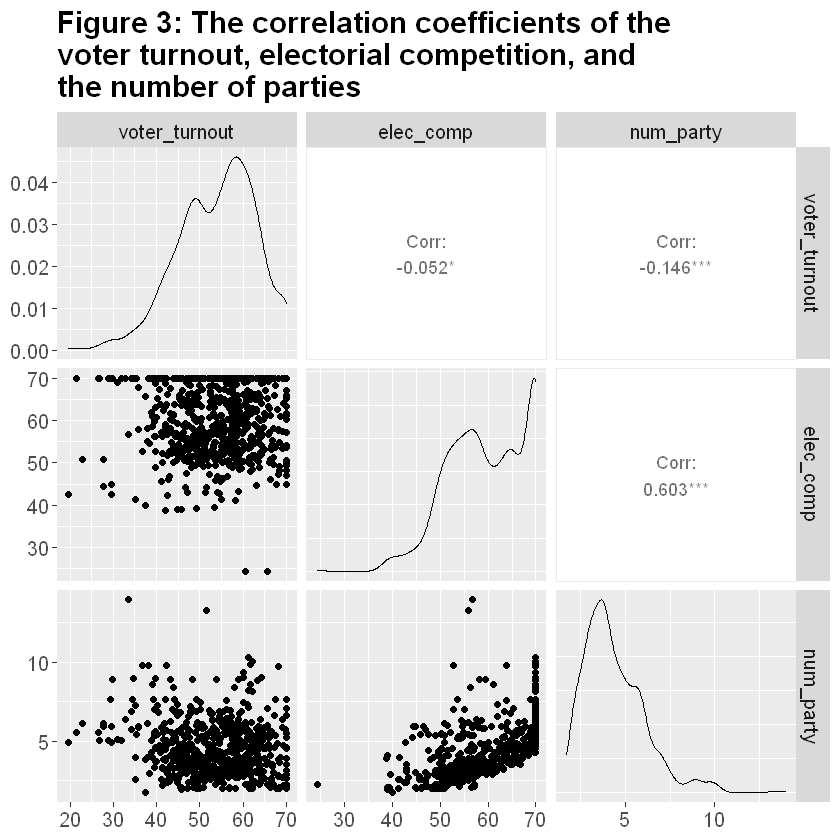

In [9]:
QOG_cleaned_pairplots <- QOG_cleaned %>%
    select(voter_turnout, elec_comp, num_party) %>%
    ggpairs(progress = FALSE) +
    theme(
      text = element_text(size = 20),
      plot.title = element_text(face = "bold"),
      axis.title = element_text(face = "bold")
    ) +
    ggtitle("Figure 3: The correlation coefficients of the
voter turnout, electorial competition, and 
the number of parties") +
    theme(text = element_text(size = 15))

QOG_cleaned_pairplots

**Voter Turnout vs. Electoral Competition:** There is a very weak negative relationship between these two variables, which corresponds to the distracted scatterplot.

**Voter Turnout vs. Effective Number of Parties:** This graph shows a weak negative relationship between the two variables, though, with the center of 4 effective parties and 55% of the participation rates, the plot is still scattered.

The main reason for this particular correlation graph is that our dataset accounts for voter data from a vast time period and a vast selection of countries with differing political landscapes, government structures, etc.

### 3.3 [TO BE ADDED]

***[THING TO DO]: ***